(toolboxes:analyze_everything)=
# Analyze everything

This notebook demonstrates how to run a complete STRESS analysis and produce all relevant output graphs. If you want to download this notebook and execute it locally on your machine, download this file as a `ipynb` Jupyter notebook file and run it in your local python environment using the download button at the top of this page.

In [1]:
import datetime
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import seaborn as sns

import napari_stress
from napari_stress import (
    TimelapseConverter,
    measurements,
    plotting,
    reconstruction,
    stress_backend,
    utils,
)

In [2]:
viewer = napari.Viewer(ndisplay=3)

In [3]:
reconstruction_parameters = None
measurement_parameters = None

## Load the data

Replace the following code with the commented out part (and remove the rest) below to load your own data for analysis:

In [4]:
image = napari_stress.get_droplet_4d()[0][0]
image.shape
filename = None

## Replace this code with a command to import your data. Example:
# filename = 'path/to/data.tif'
# image = io.imread(filename)

### Data dimensions
You need to set a few parameters pertaining to your data:

In [5]:
voxel_size_x = 2.078  # microns
voxel_size_y = 2.078  # microns
voxel_size_z = 3.998  # microns
target_voxel_size = 2.078  # microns
time_step = 3  # minutes

In [6]:
viewer.add_image(image, scale=[voxel_size_z, voxel_size_y, voxel_size_x], name='droplet')

<Image layer 'droplet' at 0x19610584bb0>

### Analysis parameters

In case you ran the reconstruction previously interactively from the napari viewer (as explained [here](toolboxes:droplet_reconstruction:interactive)) and exported the settings, you can import the settings here, too. To do so, simply uncomment the line below (remove the `#`) and provide the path to the saved settings file:

In [7]:
# reconstruction_parameters = utils.import_settings(file_name='path/of/reconstruction/settings.yaml')
# measurement_parameters = utils.import_settings(file_name='path/of/measurement/settings.yaml')

If you used a parameter file, you can skip the next step. Otherwise, use this cell to provide the necessary parameters for the reconstruction and the measurement. The parameters are explained here:
- [Reconstruction](toolboxes:droplet_reconstruction:interactive)
- [Measurement](toolboxes:stress_toolbox:stress_toolbox_interactive)

If you used the previous cell to import some parameters, skip the next cell or delete it.

In [8]:
reconstruction_parameters = {
    'voxelsize': np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
    'target_voxelsize': target_voxel_size,
    'smoothing_sigma': 1,
    'n_smoothing_iterations': 15,
    'n_points': 256,
    'n_tracing_iterations': 3,
    'resampling_length': 1,
    'fit_type': 'fancy',   # can be 'fancy' or 'quick'
    'edge_type': 'interior',   # can be 'interior' or 'surface'
    'trace_length': 20,
    'sampling_distance': 0.5,
    'interpolation_method':  'cubic',  # can be 'linear' 'cubic' or 'nearest'
    'outlier_tolerance': 1.5,
    'remove_outliers': True,
    'return_intermediate_results': True}

measurement_parameters = {
    'max_degree': 20,  # spherical harmonics degree
    'n_quadrature_points': 590,  # number of quadrature points to measure on (maximum is 5810)
    'gamma': 3.3}  # interfacial tension of droplet
alpha = 0.05  # lower and upper boundary in cumulative distribution function which should be used to calculate the stress anisotropy

*Hint:* If you are working with timelapse data, it is recommended to use parallel computation to speed up the analysis.

In [9]:
parallelize = True

# Analysis

In [10]:
n_frames = image.shape[0]

We run the reconstruction and the stress analysis:

In [11]:
results_reconstruction = reconstruction.reconstruct_droplet(image, **reconstruction_parameters, use_dask=parallelize)

for res in results_reconstruction:
    layer = napari.layers.Layer.create(res[0], res[1], res[2])
    viewer.add_layer(layer)

Dask client up and running <Client: 'tcp://127.0.0.1:50124' processes=4 threads=4, memory=31.96 GiB>  Log: http://127.0.0.1:8787/status


In [13]:
_ = stress_backend.lbdv_info(Max_SPH_Deg=measurement_parameters['max_degree'],
                             Num_Quad_Pts=measurement_parameters['n_quadrature_points'])

input_data = viewer.layers['Droplet pointcloud (smoothed)'].data
results_stress_analysis = measurements.comprehensive_analysis(input_data, **measurement_parameters,
                                                              use_dask=parallelize)

for res in results_stress_analysis:
    layer = napari.layers.Layer.create(res[0], res[1], res[2])
    viewer.add_layer(layer)

Dask client already running <Client: 'tcp://127.0.0.1:50124' processes=4 threads=4, memory=31.96 GiB>  Log: http://127.0.0.1:8787/status


To get an idea about the returned outputs and which is stored in which layer, let's print them:

In [14]:
for res in results_stress_analysis:
    print('-->', res[1]['name'])
    if 'metadata' in res[1].keys():
        for key in res[1]['metadata'].keys():
            print('\t Metadata: ', key)
    if 'features' in res[1].keys():
        for key in res[1]['features'].keys():
            print('\t Features: ', key)

--> Result of fit spherical harmonics (deg = 20)
	 Metadata:  Elipsoid_deviation_contribution_matrix
	 Metadata:  frame
	 Features:  fit_residue
	 Features:  frame
--> Result of expand points on ellipsoid
	 Features:  fit_residue
	 Features:  frame
--> Result of least squares ellipsoid
--> Result of lebedev quadrature on ellipsoid
	 Metadata:  Tissue_stress_tensor_cartesian
	 Metadata:  Tissue_stress_tensor_elliptical
	 Metadata:  Tissue_stress_tensor_elliptical_e1
	 Metadata:  Tissue_stress_tensor_elliptical_e2
	 Metadata:  Tissue_stress_tensor_elliptical_e3
	 Metadata:  stress_ellipsoid_anisotropy_e12
	 Metadata:  stress_ellipsoid_anisotropy_e23
	 Metadata:  stress_ellipsoid_anisotropy_e13
	 Metadata:  angle_ellipsoid_cartesian_e1_x1
	 Metadata:  angle_ellipsoid_cartesian_e1_x2
	 Metadata:  angle_ellipsoid_cartesian_e1_x3
	 Metadata:  stress_tissue_anisotropy
	 Metadata:  frame
	 Features:  mean_curvature
	 Features:  stress_tissue
	 Features:  frame
--> Result of lebedev quadrature 

To make handling further down easier, we store all data and metadata in a few simple dataframes

In [15]:
# Compile data
df_over_time, df_nearest_pairs, df_all_pairs, df_autocorrelations = utils.compile_data_from_layers(
    results_stress_analysis, n_frames=n_frames, time_step=time_step)

# Visualization

In this section, we will plot some interesting results and save the data to disk. The file location will be at the 

In [16]:
%%capture
figures_dict = plotting.create_all_stress_plots(
    results_stress_analysis,
    time_step=time_step,
    n_frames=n_frames
)

In [17]:
mpl.style.use('default')
colormap_time = 'flare'
if filename is not None:
    filename_without_ending = os.path.basename(filename).split('.')[0]
    save_directory = os.path.join(os.path.dirname(filename), filename_without_ending + '_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
else:
    save_directory = os.path.join(os.getcwd(), 'results_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

## Fit errors

We first show all the errors that were calculated during the pointcloud refinement:

In [18]:
fit_error_df = pd.DataFrame(results_reconstruction[3][1]['features'].reset_index())
fit_error_df

,index,center,amplitude,slope,background_slope,offset,center_err,amplitude_err,slope_err,background_slope_err,offset_err,distance_to_nearest_neighbor,mean_squared_error,fraction_variance_unexplained,fraction_variance_unexplained_log,idx_of_border,frame
0,0,20.038063,176.410822,-0.673940,-1.168413,4.609321e-21,0.046695,2.582717,0.012938,0.307859,0.566758,1.099930,20.261058,0.004435,-5.418143,20.038063,0
1,1,20.022966,163.568899,-0.638404,0.379437,5.848198e-20,0.047042,2.414873,0.011207,0.275440,0.485870,1.096523,6.302603,0.001248,-6.686067,20.022966,0
2,2,20.025295,193.242245,-0.673258,-2.377362,1.104042e-18,0.044560,2.653223,0.012399,0.321607,0.599573,1.118846,33.819470,0.007118,-4.945105,20.025295,0
3,3,20.025143,163.229563,-0.641114,0.257542,1.242458e-21,0.047908,2.453894,0.011555,0.280890,0.497471,1.031137,10.036452,0.002015,-6.207211,20.025143,0
4,4,20.003009,176.166124,-0.670780,-0.900823,3.622026e-20,0.048619,2.688943,0.013216,0.320005,0.577818,1.076207,10.774460,0.002298,-6.075505,20.003009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15364,725,19.998927,197.392632,-0.627527,-3.770612,3.676951e-01,0.018876,0.962403,0.004785,0.103900,0.237937,1.031561,17.373360,0.003571,-5.634947,19.998927,20
15365,726,20.040552,171.129640,-0.677093,-1.781867,3.194370e-14,0.029979,1.459065,0.009372,0.152425,0.390491,1.131636,18.176025,0.003844,-5.561195,20.040552,20
15366,727,19.995654,179.672688,-0.667468,-2.447113,6.488004e-22,0.025294,1.271959,0.007641,0.134078,0.340907,1.085043,15.459548,0.003339,-5.702091,19.995654,20
15367,728,19.992411,192.269531,-0.652320,-3.107330,1.823652e-16,0.023571,1.247022,0.006770,0.131471,0.335464,1.074869,19.429097,0.003838,-5.562913,19.992411,20


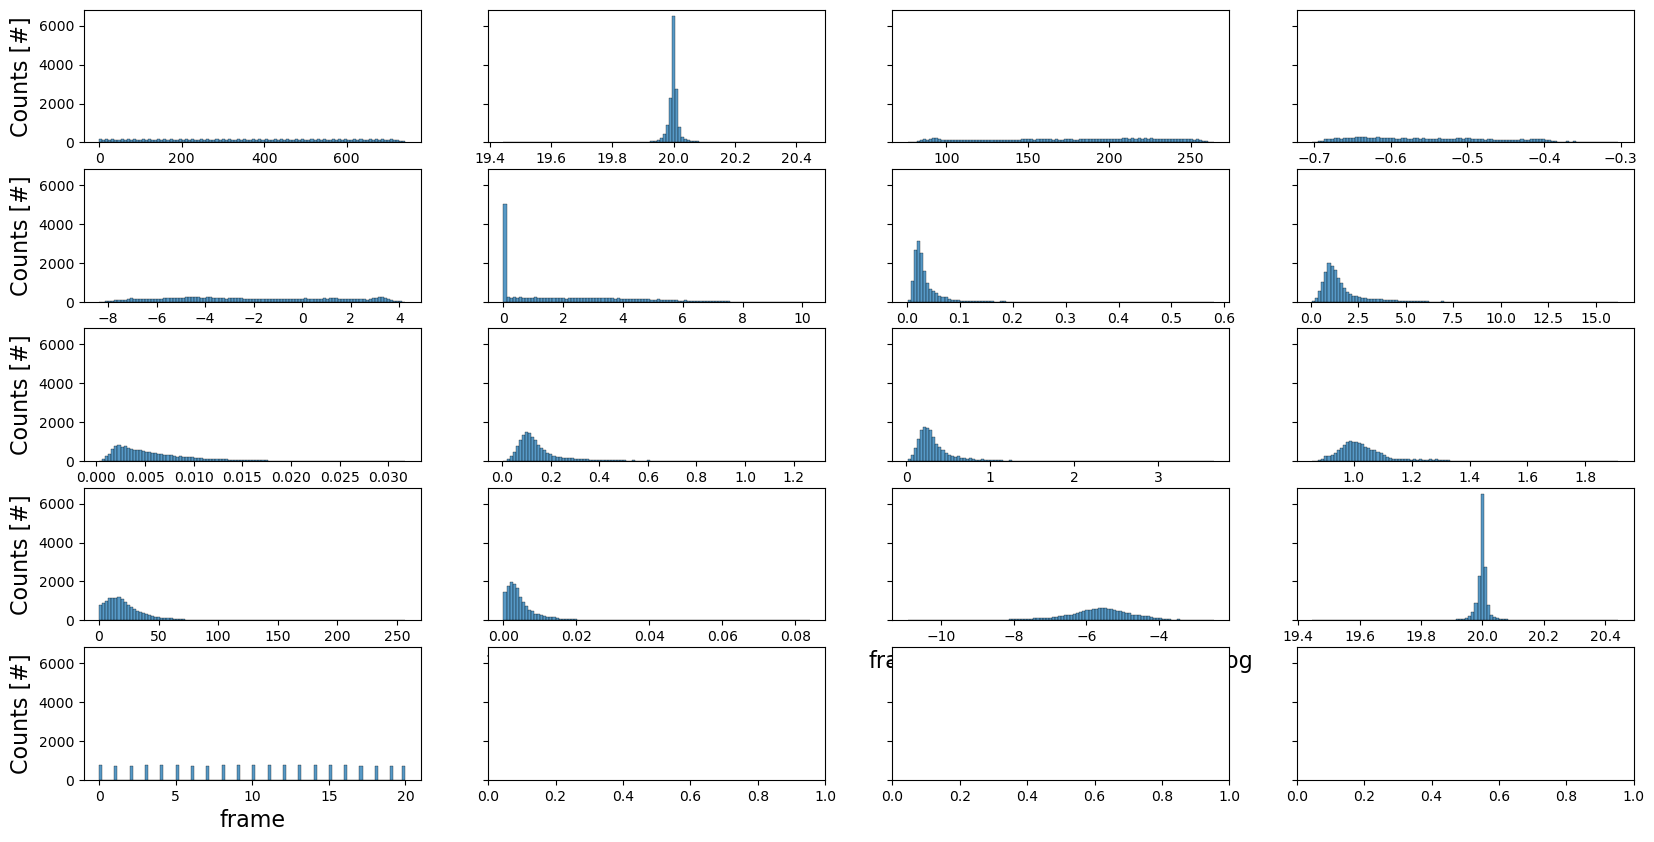

In [19]:
fig, axes = plt.subplots(ncols=4, nrows=len(fit_error_df.columns)//4+1, figsize=(20, 10), sharey=True)
axes = axes.flatten()
for idx, column in enumerate(fit_error_df.columns):
    ax = axes[idx]

    sns.histplot(data=fit_error_df, x=column, ax=ax, bins=100)
    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Counts [#]', fontsize=16)

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'fit_error_reconstruction.png'), dpi=300)

## Spherical harmonics

### Fit residue

We now show the errors made when approximating the reconstructed pointcloud with the spherical harmonics:

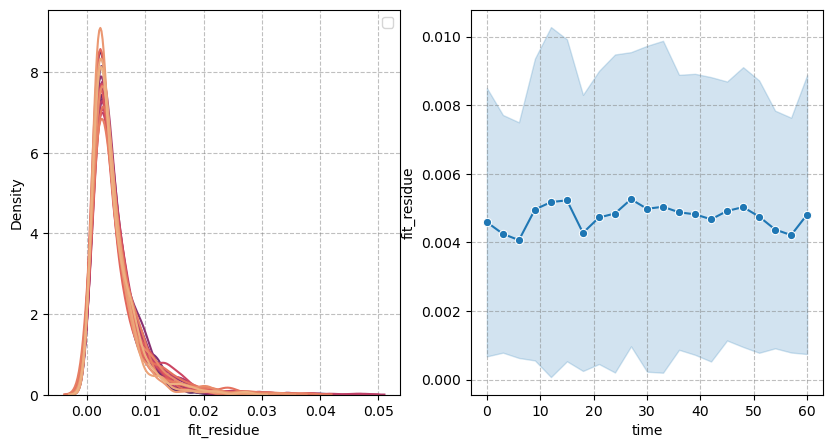

In [20]:
figure = figures_dict['Figure_reside']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

### Fit quality

We can quantify the quality of the extracted pointcloud by using the absolute and relative Gauss-Bonnet errors:

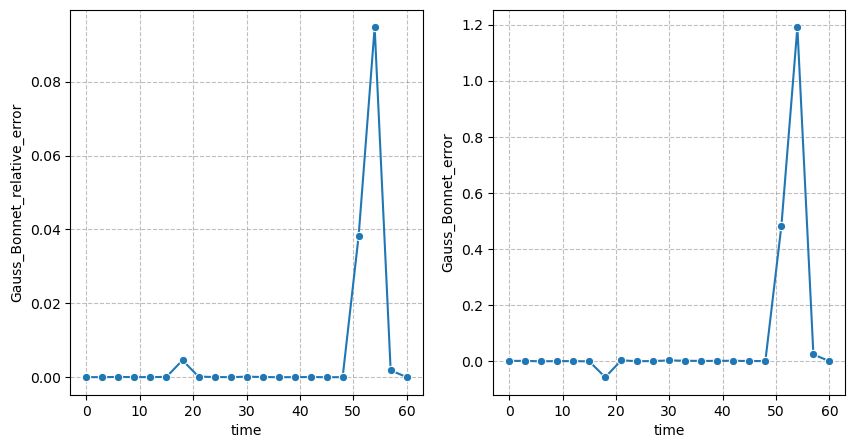

In [21]:
figure = figures_dict['fig_GaussBonnet_error']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

## Curvature

We next show mean curvature histograms and averages over time:

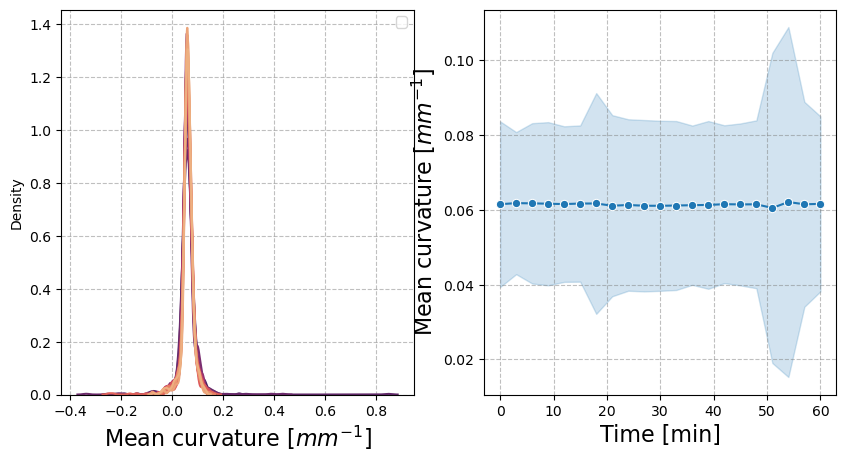

In [22]:
figure = figures_dict['fig_mean_curvature']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure'].axes[0].set_xlabel("Mean curvature [$mm^{-1}$]", fontsize=16)

figure['figure'].axes[1].set_ylabel("Mean curvature [$mm^{-1}$]", fontsize=16)
figure['figure'].axes[1].set_xlabel("Time [min]", fontsize=16)

figure['figure']

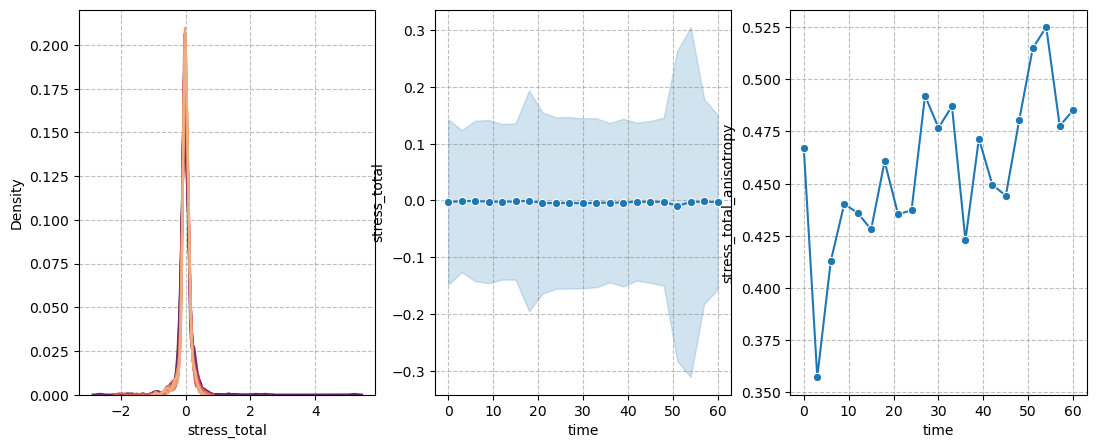

In [23]:
figure = figures_dict['fig_total_stress']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

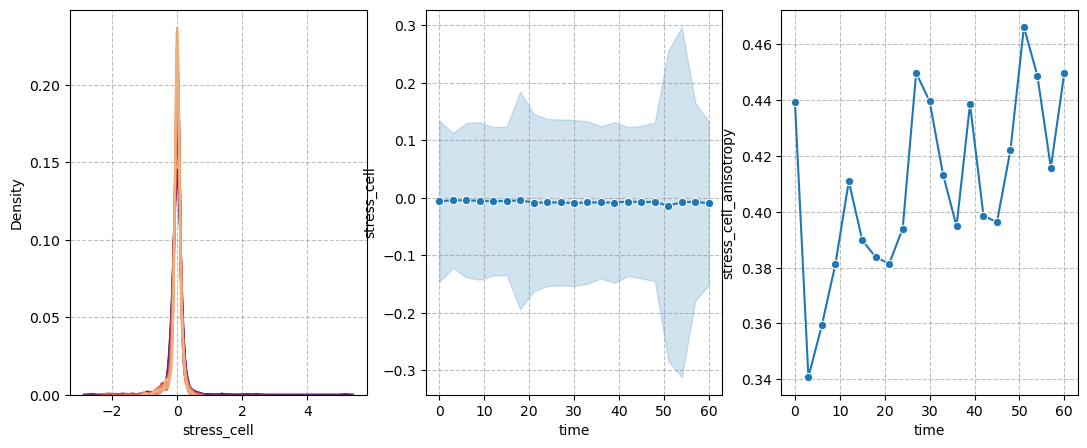

In [24]:
figure = figures_dict['fig_cell_stress']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

## Tissue-scale stresses

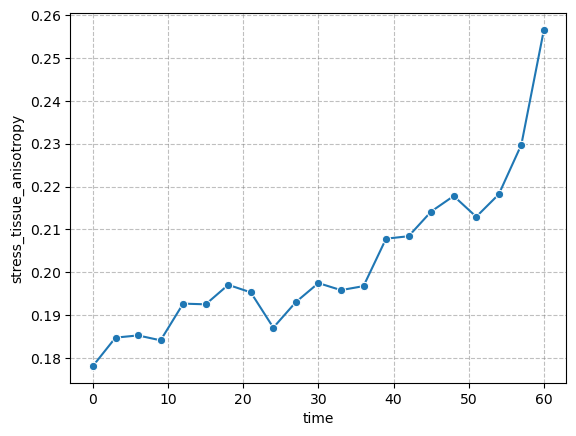

In [25]:
figure = figures_dict['fig_tissue_stress']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

## Stress along axes

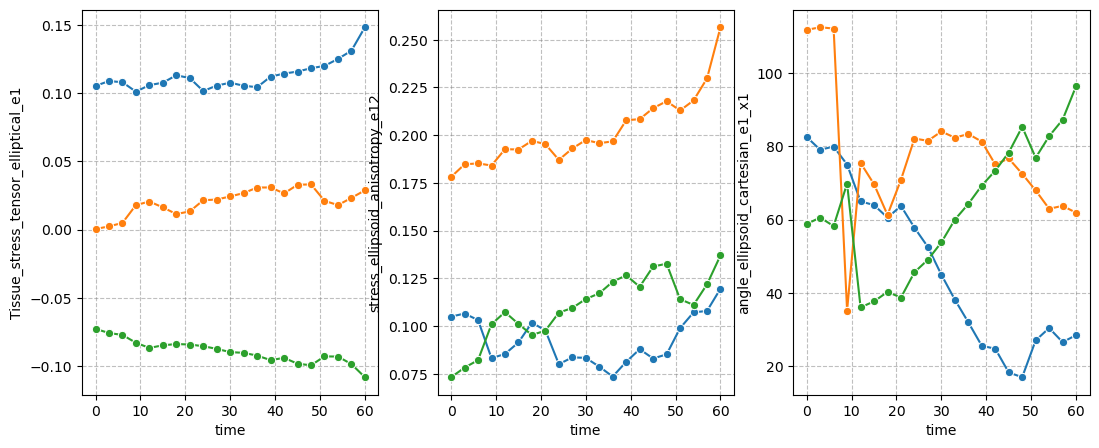

In [26]:
figure = figures_dict['fig_stress_tensor']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

## Extrema analysis

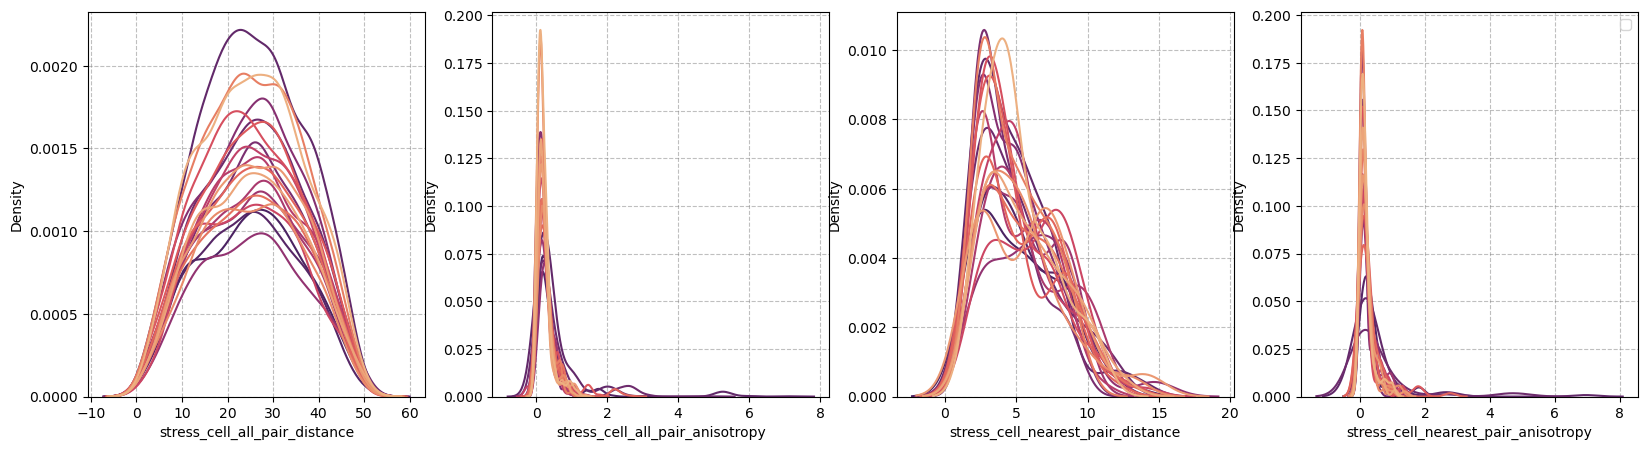

In [27]:
figure = figures_dict['fig_all_pairs']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

##  Autocorrelations: Spatial

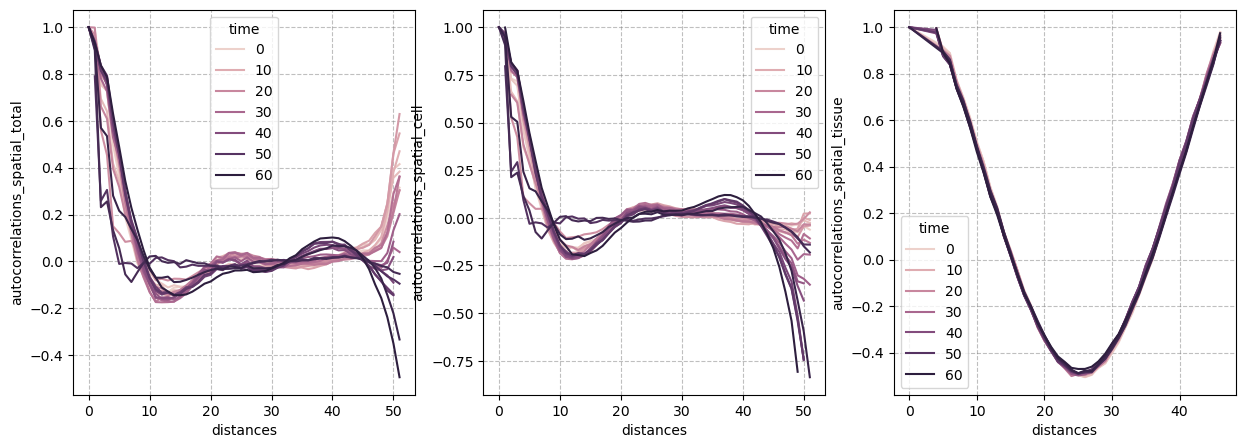

In [28]:
figure = figures_dict['fig_spatial_autocorrelation']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

## Autocorrelations: Temporal

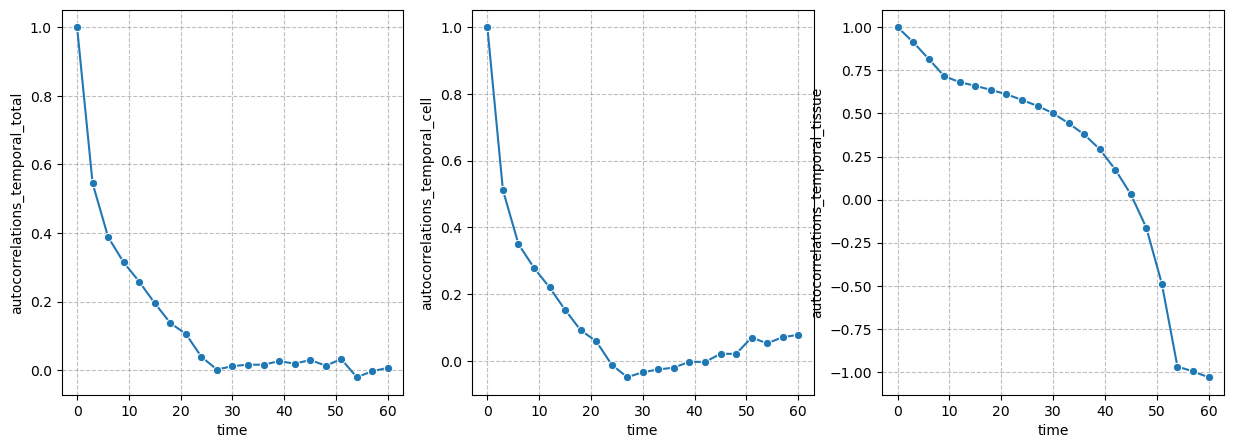

In [29]:
figure = figures_dict['fig_temporal_autocorrelation']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

## Ellipsoid deviation

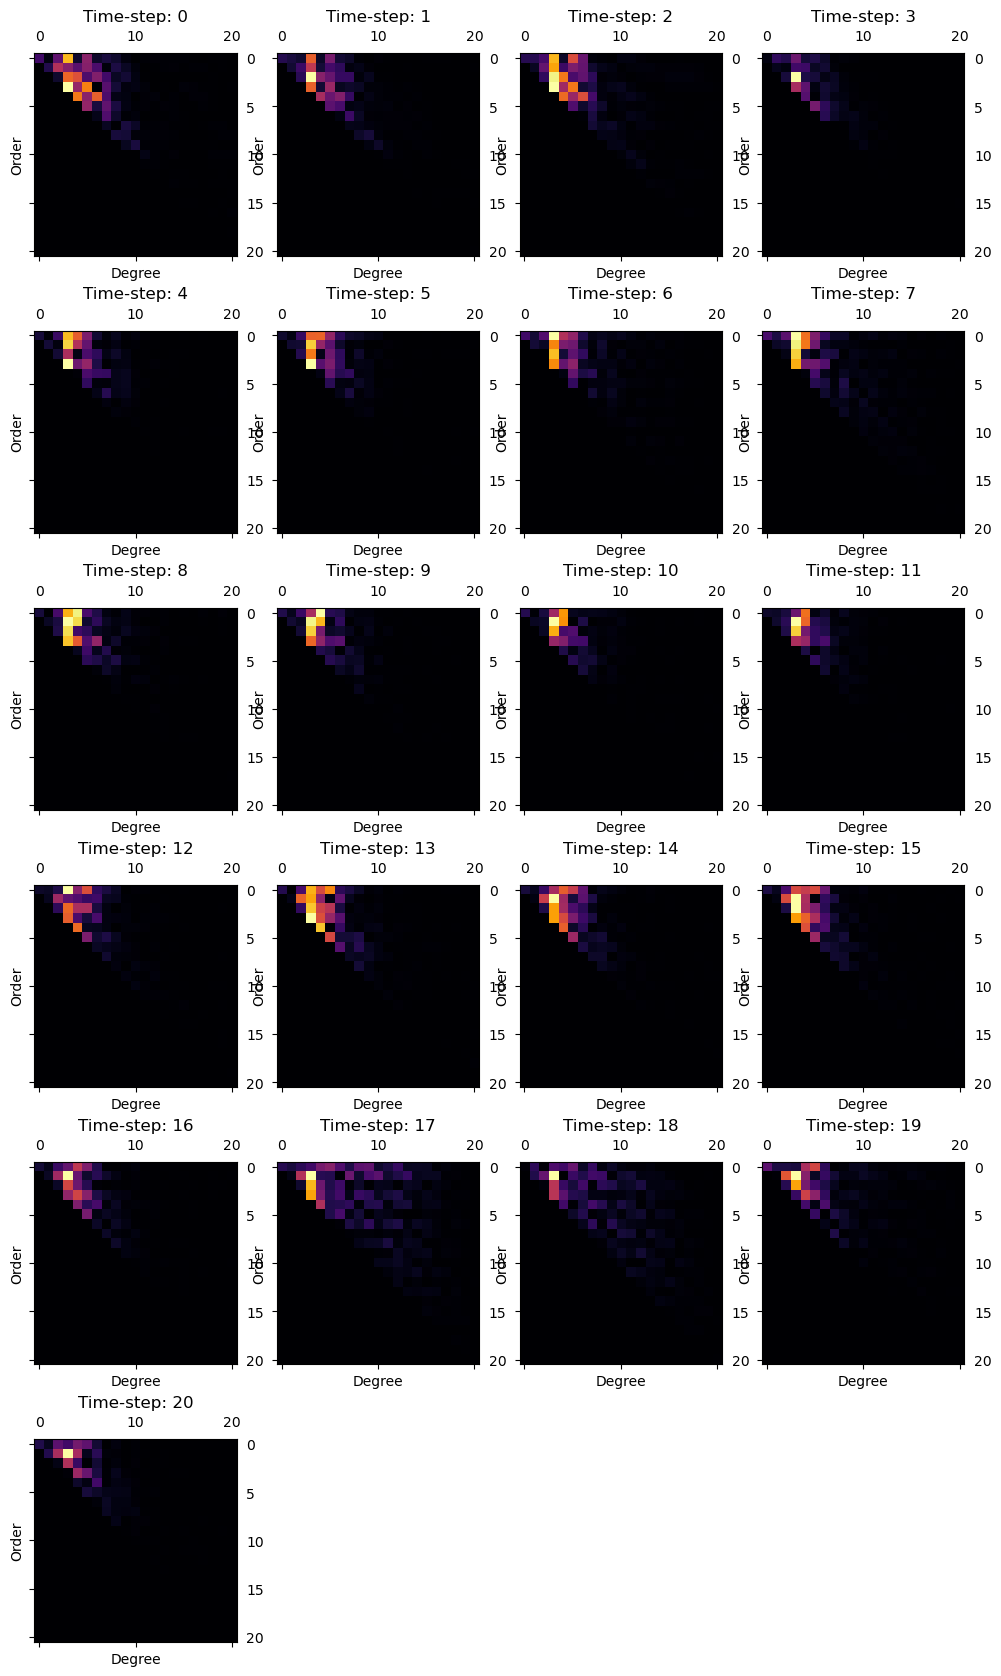

In [30]:
figure = figures_dict['fig_ellipsoid_contribution']
if save_directory is not None:
    figure['figure'].savefig(os.path.join(save_directory, figure['path']), dpi=300)

figure['figure']

## Droplet movement

This analyzes how much the center of the droplet moves over time.

<Axes: xlabel='time', ylabel='droplet_center_displacement'>

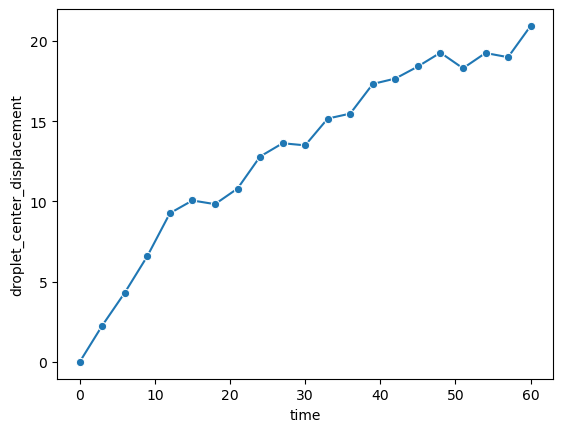

In [31]:
Converter = TimelapseConverter()
list_of_points = Converter.data_to_list_of_data(results_reconstruction[3][0], layertype=napari.types.PointsData)
center = [np.mean(points, axis=0) for points in list_of_points]
center_displacement = np.asarray([np.linalg.norm(center[t] - center[0]) for t in range(n_frames)])
df_over_time['droplet_center_displacement'] =  center_displacement * target_voxel_size

sns.lineplot(data=df_over_time, x='time', y='droplet_center_displacement', marker='o')

## Export data

We first agregate the data from the spatial autocorrelations in a separate dataframe. This dataframe has a column for autocorrelations of total, cell and tissue-scale stresses.

In [32]:
df_to_export = pd.DataFrame()
for col in df_over_time.columns:
    if isinstance(df_over_time[col].iloc[0], np.ndarray):
        continue
    if np.stack(df_over_time[col].to_numpy()).shape == (n_frames,):
        df_to_export[col] = df_over_time[col].to_numpy()

df_to_export.to_csv(os.path.join(save_directory, 'results_over_time.csv'), index=False)

We also export the used settings for the analysis  into a `.yml` file:

In [33]:
utils.export_settings(reconstruction_parameters, file_name=os.path.join(save_directory, 'reconstruction_settings.yaml'))
utils.export_settings(measurement_parameters, file_name=os.path.join(save_directory, 'measurement_settings.yaml'))